In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet

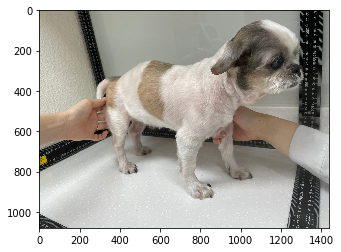

In [2]:
image = Image.open('/home/jh20/Data/pet/alldata/A_10_DRI_IF_20221016_10_000083_10.jpg')
plt.imshow(image)

In [26]:
transforms_ex = transforms.Compose([
        transforms.Resize(300),  # 사이즈 변경
        transforms.CenterCrop(299),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [62]:
transforms_ex1 = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomVerticalFlip(p=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


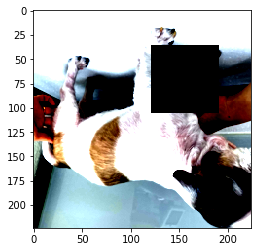

In [63]:
image = transforms_ex1(image)

image = cutout(image)

image = image.permute(1,2,0)

plt.imshow(image)

In [2]:
pet_df = pd.read_csv("/home/jh20/Data/pet/pet_df.csv")

In [3]:
pet_df.drop_duplicates(['mission-id'])[['mission-id','breed']].groupby('breed').count()

,mission-id
breed,
CHI,31
DRI,38
ETC,163
GOL,8
JIN,6
KOR,6
MAL,168
MIX,50
PER,3


In [4]:
DRI_df = pet_df[pet_df['breed']=='DRI']
DRI_df = DRI_df.loc[~DRI_df['body-part'].isin([1,2,13,14,15,16,17,18,19,20]),:]
DRI_df

,type,species,mission-id,provider-code,breed,age,class,sex,weight,shoulder-height,...,environment,defecation,food-amount,snack-amount,food-kind,image-id,label,points,shape,part
30,A,10,10_000083,2,DRI,12.0,SS,IF,3.50,22.0,...,1,1,1.0,20.0,1,A_10_DRI_IF_20221016_10_000083_10.jpg,전신,"[[287, 48], [1319, 943]]",Bounding Box,우측면우45도
32,A,10,10_000083,2,DRI,12.0,SS,IF,3.50,22.0,...,1,1,1.0,20.0,1,A_10_DRI_IF_20221016_10_000083_04.jpg,전신,"[[230, 99], [1322, 1055]]",Bounding Box,좌측면좌45도
33,A,10,10_000083,2,DRI,12.0,SS,IF,3.50,22.0,...,1,1,1.0,20.0,1,A_10_DRI_IF_20221016_10_000083_11.jpg,전신,"[[64, 139], [1439, 954]]",Bounding Box,우측면상45도
34,A,10,10_000083,2,DRI,12.0,SS,IF,3.50,22.0,...,1,1,1.0,20.0,1,A_10_DRI_IF_20221016_10_000083_09.jpg,전신,"[[151, 166], [1154, 1078]]",Bounding Box,우측면좌45도
36,A,10,10_000083,2,DRI,12.0,SS,IF,3.50,22.0,...,1,1,1.0,20.0,1,A_10_DRI_IF_20221016_10_000083_03.jpg,전신,"[[88, 187], [1404, 940]]",Bounding Box,좌측면중앙
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12148,A,10,10_100806,38,DRI,1.0,SS,SF,4.35,25.0,...,1,1,0.5,1.0,1,A_10_DRI_SF_20221130_10_100806_06.jpg,전신,"[[122, 224], [1337, 891]]",Bounding Box,좌측면상45도
12149,A,10,10_100806,38,DRI,1.0,SS,SF,4.35,25.0,...,1,1,0.5,1.0,1,A_10_DRI_SF_20221130_10_100806_07.jpg,전신,"[[260, 178], [1220, 889]]",Bounding Box,좌측면하45도
12150,A,10,10_100806,38,DRI,1.0,SS,SF,4.35,25.0,...,1,1,0.5,1.0,1,A_10_DRI_SF_20221130_10_100806_10.jpg,전신,"[[408, 176], [1252, 916]]",Bounding Box,우측면우45도
12151,A,10,10_100806,38,DRI,1.0,SS,SF,4.35,25.0,...,1,1,0.5,1.0,1,A_10_DRI_SF_20221130_10_100806_12.jpg,전신,"[[115, 220], [1239, 832]]",Bounding Box,우측면하45도


In [5]:
# CHI_df.assign(fat = lambda x : 1 if x['BCS']> 5 else 0)

def fat(x):
    
    if x <= 5:
        y=0
    else:
        y=1
    return y


DRI_df = DRI_df.assign(fat = DRI_df['BCS'].apply(lambda x : fat(x)))

In [6]:
data_subdf1 = DRI_df[['mission-id','fat']]
data_subdf1.drop_duplicates(inplace=True)
data_subdf1

/home/jh20/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,mission-id,fat
30,10_000083,0
58,10_000092,0
1562,10_000453,0
2394,10_000697,0
2699,10_000793,0
3049,10_000835,1
3560,10_000877,0
3774,10_000891,1
3960,10_000902,1
4002,10_000904,0


In [7]:
DRI_df.fat.value_counts()

0    184
1    146
Name: fat, dtype: int64

In [8]:
data_subdf2 = DRI_df[['mission-id','fat','image-id']]
data_subdf2.drop_duplicates(inplace=True)
data_subdf2

/home/jh20/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,mission-id,fat,image-id
30,10_000083,0,A_10_DRI_IF_20221016_10_000083_10.jpg
32,10_000083,0,A_10_DRI_IF_20221016_10_000083_04.jpg
33,10_000083,0,A_10_DRI_IF_20221016_10_000083_11.jpg
34,10_000083,0,A_10_DRI_IF_20221016_10_000083_09.jpg
36,10_000083,0,A_10_DRI_IF_20221016_10_000083_03.jpg
...,...,...,...
12148,10_100806,0,A_10_DRI_SF_20221130_10_100806_06.jpg
12149,10_100806,0,A_10_DRI_SF_20221130_10_100806_07.jpg
12150,10_100806,0,A_10_DRI_SF_20221130_10_100806_10.jpg
12151,10_100806,0,A_10_DRI_SF_20221130_10_100806_12.jpg


In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(data_subdf1['mission-id'],data_subdf1.fat,test_size=0.2,random_state=42)

In [10]:
x_train

7684     10_001214
5941     10_001089
6115     10_001098
3960     10_000902
5981     10_001091
5307     10_001024
6177     10_001103
4002     10_000904
9946     10_001515
30       10_000083
8101     10_001240
3049     10_000835
5193     10_001013
58       10_000092
12134    10_100806
6572     10_001133
1562     10_000453
9035     10_001456
11701    10_001631
2394     10_000697
10191    10_001529
7046     10_001160
9935     10_001514
4679     10_000960
6873     10_001150
6157     10_001101
6418     10_001121
3774     10_000891
5649     10_001074
8894     10_001433
Name: mission-id, dtype: object

In [11]:
x_valid

10001    10_001518
11714    10_001632
2699     10_000793
5551     10_001069
9649     10_001497
8229     10_001255
3560     10_000877
8764     10_001426
Name: mission-id, dtype: object

In [12]:
y_train.value_counts()

0    17
1    13
Name: fat, dtype: int64

In [13]:
y_valid.value_counts()

0    5
1    3
Name: fat, dtype: int64

In [14]:
data_dir = '/home/jh20/Data/pet/alldata/'

In [15]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [16]:
class TorchvisionDataset(Dataset):
    def __init__(self, data_dir, x, y ,df, transform=None, cutout=None):
        self.data_dir = data_dir
        self.transform = transform
        self.cutout = cutout
        
        file_paths=[]
        labels=[]
        for (i,j,k,l) in df.itertuples():
            if j in list(x):
                file_paths.append(l)  #이미지 경로
                labels.append(k)   # label 생성
            
        self.file_paths = file_paths
        self.labels = labels
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file = self.file_paths[idx]
        
        file_path = data_dir + file
        
        # Read an image with PIL
        image = Image.open(file_path)  #이미지 텐서로 변형
        

        if self.transform:   # 전처리(resize, noramlization) 및 vertical flip 적용
            image = self.transform(image)
            
        if self.cutout:
            image = self.cutout(image)  # cutout 적용

        return image, label , file_path

In [17]:
train_transforms = transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(299),
        transforms.RandomVerticalFlip(p=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
        transforms.Resize(300),  # 사이즈 변경
        transforms.CenterCrop(299),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


cutout = Cutout(1,70)


train_dataset = TorchvisionDataset(data_dir,x_train,y_train,data_subdf2,train_transforms,cutout)
valid_dataset = TorchvisionDataset(data_dir,x_valid,y_valid,data_subdf2,valid_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=64,
                                             shuffle=True, num_workers=4)

valid_dataloader = DataLoader(valid_dataset, batch_size=8,
                                             shuffle=True, num_workers=4)
dataloaders = {'train' :train_dataloader, 'val' : valid_dataloader}


train_dataset_sizes = len(train_dataset)
valid_dataset_sizes = len(valid_dataset)


dataset_sizes = {'train' : train_dataset_sizes, 'val' : valid_dataset_sizes}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
train_dataset = TorchvisionDataset(data_dir,x_train,y_train,data_subdf2,train_transforms,cutout)

print(train_dataset[0])

print()

print('-'*50)

print()

print(len(train_dataset))

(tensor([[[ 1.4269,  1.4440,  1.4098,  ..., -0.6109, -0.7479, -1.0904],
         [ 1.3927,  1.4098,  1.4098,  ..., -0.8335, -0.7137, -0.8678],
         [ 1.3755,  1.3927,  1.4098,  ..., -0.8507, -0.8849, -0.9192],
         ...,
         [-0.1657, -0.0116, -0.5767,  ...,  0.5364,  0.5022,  0.4851],
         [-0.0629, -0.0801, -0.7822,  ...,  0.5364,  0.5193,  0.5022],
         [-0.1486, -0.3198, -0.9192,  ...,  0.5193,  0.5022,  0.4851]],

        [[ 1.6232,  1.6408,  1.6057,  ..., -0.4251, -0.5651, -0.9503],
         [ 1.5882,  1.6057,  1.6057,  ..., -0.6352, -0.4951, -0.7052],
         [ 1.5357,  1.5532,  1.5707,  ..., -0.6877, -0.7227, -0.7227],
         ...,
         [-0.1275,  0.0126, -0.5301,  ...,  0.7304,  0.6954,  0.6779],
         [-0.0049, -0.0399, -0.7227,  ...,  0.7304,  0.7129,  0.6954],
         [-0.0749, -0.3025, -0.8277,  ...,  0.7129,  0.6954,  0.6779]],

        [[ 1.8034,  1.8383,  1.8034,  ..., -0.1835, -0.3230, -0.7413],
         [ 1.7685,  1.7860,  1.8034,  ..., -

In [19]:
valid_dataset = TorchvisionDataset(data_dir,x_valid,y_valid,data_subdf2,valid_transforms)
print(valid_dataset[0])
print()
print('-'*50)
print()
print(len(valid_dataset))

(tensor([[[-0.2342,  0.1254,  0.3481,  ...,  1.5125,  1.5810,  1.6324],
         [-0.2684,  0.0569,  0.2796,  ...,  1.5468,  1.6153,  1.6495],
         [-0.2684,  0.0569,  0.2796,  ...,  1.5810,  1.6324,  1.6667],
         ...,
         [-0.2856, -0.3541, -0.2684,  ..., -1.7925, -1.7925, -1.7925],
         [-0.2856, -0.1999, -0.0287,  ..., -1.7925, -1.7925, -1.7925],
         [ 0.2282,  0.0569, -0.1486,  ..., -1.7925, -1.7925, -1.7925]],

        [[-0.0399,  0.3277,  0.5553,  ...,  1.5882,  1.6583,  1.7108],
         [-0.0749,  0.2577,  0.4853,  ...,  1.6232,  1.6933,  1.7283],
         [-0.0749,  0.2577,  0.4853,  ...,  1.6583,  1.7108,  1.7458],
         ...,
         [-0.0049, -0.0399,  0.0301,  ..., -1.6506, -1.6506, -1.6506],
         [ 0.0476,  0.1001,  0.2577,  ..., -1.6506, -1.6506, -1.6506],
         [ 0.5903,  0.3627,  0.1352,  ..., -1.6331, -1.6331, -1.6331]],

        [[ 0.2348,  0.6008,  0.8274,  ...,  1.7337,  1.8034,  1.8557],
         [ 0.1999,  0.5311,  0.7576,  ...,  

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=128,
                                             shuffle=True, num_workers=4)

valid_dataloader = DataLoader(valid_dataset, batch_size=8,
                                             shuffle=True, num_workers=4)
dataloaders = {'train' :train_dataloader, 'val' : valid_dataloader}


train_dataset_sizes = len(train_dataset)
valid_dataset_sizes = len(valid_dataset)


dataset_sizes = {'train' : train_dataset_sizes, 'val' : valid_dataset_sizes}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    _, preds = torch.max(outputs.data, dim= 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [30]:
model_resnet34 = models.resnet34(pretrained=True)
num_ftrs = model_resnet34.fc.in_features

model_resnet34.fc = nn.Linear(num_ftrs, 2)

model_resnet34 = model_resnet34.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_resnet34.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)


model_resnet34 = train_model(model_resnet34, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6827 Acc: 0.6364
val Loss: 1.5200 Acc: 0.4026

Epoch 1/24
----------
train Loss: 0.3653 Acc: 0.8419
val Loss: 0.5004 Acc: 0.7922

Epoch 2/24
----------
train Loss: 0.2221 Acc: 0.9170
val Loss: 5.8911 Acc: 0.4545

Epoch 3/24
----------
train Loss: 0.2569 Acc: 0.9209
val Loss: 15.9625 Acc: 0.3636

Epoch 4/24
----------
train Loss: 0.1228 Acc: 0.9565
val Loss: 2.5012 Acc: 0.7013

Epoch 5/24
----------
train Loss: 0.0589 Acc: 0.9763
val Loss: 3.7202 Acc: 0.7143

Epoch 6/24
----------
train Loss: 0.0290 Acc: 0.9881
val Loss: 1.3643 Acc: 0.8442

Epoch 7/24
----------
train Loss: 0.0303 Acc: 0.9842
val Loss: 6.5382 Acc: 0.6104

Epoch 8/24
----------
train Loss: 0.0127 Acc: 1.0000
val Loss: 8.5294 Acc: 0.5584

Epoch 9/24
----------
train Loss: 0.0130 Acc: 0.9960
val Loss: 6.3248 Acc: 0.5455

Epoch 10/24
----------
train Loss: 0.0127 Acc: 0.9960
val Loss: 3.2727 Acc: 0.6364

Epoch 11/24
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 2.0761 Acc: 0.7143

E

In [29]:
model_resnet34 = models.resnet34(pretrained=True)
num_ftrs = model_resnet34.fc.in_features

model_resnet34.fc = nn.Linear(num_ftrs, 2)


update_param_names = ['fc.weight', 'fc.bias']
for name, param in model_resnet34.named_parameters() :
    if name in update_param_names : 
        param.requires_grad = True
        print(name)
    else :
        param.requires_grad = False

model_resnet34 = model_resnet34.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_resnet34.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)


model_resnet34 = train_model(model_resnet34, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

fc.weight
fc.bias
Epoch 0/24
----------
train Loss: 0.7998 Acc: 0.4901
val Loss: 0.6533 Acc: 0.5844

Epoch 1/24
----------
train Loss: 0.7377 Acc: 0.5692
val Loss: 0.6026 Acc: 0.6234

Epoch 2/24
----------
train Loss: 0.6904 Acc: 0.5889
val Loss: 0.6117 Acc: 0.6753

Epoch 3/24
----------
train Loss: 0.6393 Acc: 0.6443
val Loss: 0.6686 Acc: 0.6234

Epoch 4/24
----------
train Loss: 0.6330 Acc: 0.6522
val Loss: 0.6633 Acc: 0.6364

Epoch 5/24
----------
train Loss: 0.5930 Acc: 0.7154
val Loss: 0.5973 Acc: 0.6753

Epoch 6/24
----------
train Loss: 0.5533 Acc: 0.7628
val Loss: 0.5293 Acc: 0.7403

Epoch 7/24
----------
train Loss: 0.5417 Acc: 0.7549
val Loss: 0.4926 Acc: 0.8312

Epoch 8/24
----------
train Loss: 0.5201 Acc: 0.7589
val Loss: 0.4778 Acc: 0.8571

Epoch 9/24
----------
train Loss: 0.5019 Acc: 0.7668
val Loss: 0.4672 Acc: 0.8831

Epoch 10/24
----------
train Loss: 0.4977 Acc: 0.7747
val Loss: 0.4665 Acc: 0.8182

Epoch 11/24
----------
train Loss: 0.4843 Acc: 0.8024
val Loss: 0.46

In [22]:
model_resnet34 = models.resnet34(pretrained=True)
num_ftrs = model_resnet34.fc.in_features

model_resnet34.fc = nn.Linear(num_ftrs, 2)


update_param_names = ['fc.weight', 'fc.bias']
for name, param in model_resnet34.named_parameters() :
    if name in update_param_names : 
        param.requires_grad = True
        print(name)
    else :
        param.requires_grad = False

model_resnet34 = model_resnet34.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_resnet34.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)


model_resnet34 = train_model(model_resnet34, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

fc.weight
fc.bias
Epoch 0/24
----------
train Loss: 0.7690 Acc: 0.5178
val Loss: 0.5851 Acc: 0.6623

Epoch 1/24
----------
train Loss: 0.7304 Acc: 0.5059
val Loss: 0.5586 Acc: 0.7013

Epoch 2/24
----------
train Loss: 0.6747 Acc: 0.5929
val Loss: 0.5562 Acc: 0.6623

Epoch 3/24
----------
train Loss: 0.6546 Acc: 0.6403
val Loss: 0.5611 Acc: 0.6364

Epoch 4/24
----------
train Loss: 0.6410 Acc: 0.6126
val Loss: 0.5296 Acc: 0.6753

Epoch 5/24
----------
train Loss: 0.6092 Acc: 0.6680
val Loss: 0.5021 Acc: 0.7143

Epoch 6/24
----------
train Loss: 0.5800 Acc: 0.7194
val Loss: 0.4889 Acc: 0.8052

Epoch 7/24
----------
train Loss: 0.5530 Acc: 0.7352
val Loss: 0.4788 Acc: 0.8052

Epoch 8/24
----------
train Loss: 0.5413 Acc: 0.7431
val Loss: 0.4714 Acc: 0.7532

Epoch 9/24
----------
train Loss: 0.5414 Acc: 0.7549
val Loss: 0.4716 Acc: 0.7273

Epoch 10/24
----------
train Loss: 0.5236 Acc: 0.7589
val Loss: 0.4650 Acc: 0.7403

Epoch 11/24
----------
train Loss: 0.4989 Acc: 0.7510
val Loss: 0.45

In [ ]:
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features

model_resnet18.fc = nn.Linear(num_ftrs, 2)


model_resnet18 = model_resnet18.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_resnet18.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)


model_resnet18,  preds_val, preds_train = train_model(model_resnet18, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4631 Acc: 0.8432
val Loss: 8.7441 Acc: 0.7209

Epoch 1/24
----------
train Loss: 0.2608 Acc: 0.9083
val Loss: 1.6101 Acc: 0.6744

Epoch 2/24
----------
train Loss: 0.1649 Acc: 0.9300
val Loss: 2.2240 Acc: 0.4612

Epoch 3/24
----------
train Loss: 0.1121 Acc: 0.9596
val Loss: 0.9808 Acc: 0.7287

Epoch 4/24
----------
train Loss: 0.0873 Acc: 0.9655
val Loss: 2.5897 Acc: 0.7209

Epoch 5/24
----------
train Loss: 0.0581 Acc: 0.9842
val Loss: 2.0316 Acc: 0.7016

Epoch 6/24
----------
train Loss: 0.0201 Acc: 0.9961
val Loss: 1.4342 Acc: 0.7171

Epoch 7/24
----------
train Loss: 0.0174 Acc: 0.9951
val Loss: 1.7158 Acc: 0.7248

Epoch 8/24
----------
train Loss: 0.0148 Acc: 0.9931
val Loss: 2.3656 Acc: 0.7209

Epoch 9/24
----------
train Loss: 0.0161 Acc: 0.9941
val Loss: 1.5587 Acc: 0.7287

Epoch 10/24
----------
train Loss: 0.0104 Acc: 0.9961
val Loss: 1.2840 Acc: 0.7287

Epoch 11/24
----------
train Loss: 0.0079 Acc: 0.9990
val Loss: 1.5524 Acc: 0.7248

Ep

In [31]:
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features

model_resnet18.fc = nn.Linear(num_ftrs, 2)  # 전이 학습을 위해 fc 레이어 다운스트림 테스크에 맞게 변경

update_param_names = ['fc.weight', 'fc.bias']
for name, param in model_resnet18.named_parameters() :
    if name in update_param_names : 
        param.requires_grad = True  # 역전파 가능하게 만듬
        print(name)
    else :
        param.requires_grad = False  # 파라미터 freeze


model_resnet18 = model_resnet18.to(device)  # GPU 학습

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_resnet18.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95) 


model_resnet18 = train_model(model_resnet18, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

fc.weight
fc.bias
Epoch 0/24
----------
train Loss: 0.7579 Acc: 0.4743
val Loss: 0.5943 Acc: 0.7403

Epoch 1/24
----------
train Loss: 0.6963 Acc: 0.5415
val Loss: 0.5411 Acc: 0.6753

Epoch 2/24
----------
train Loss: 0.6486 Acc: 0.6047
val Loss: 0.4890 Acc: 0.7792

Epoch 3/24
----------
train Loss: 0.6156 Acc: 0.6680
val Loss: 0.4435 Acc: 0.8701

Epoch 4/24
----------
train Loss: 0.5745 Acc: 0.7352
val Loss: 0.4115 Acc: 0.9351

Epoch 5/24
----------
train Loss: 0.5485 Acc: 0.7470
val Loss: 0.3840 Acc: 0.9221

Epoch 6/24
----------
train Loss: 0.5121 Acc: 0.7905
val Loss: 0.3627 Acc: 0.9091

Epoch 7/24
----------
train Loss: 0.5072 Acc: 0.7510
val Loss: 0.3474 Acc: 0.9221

Epoch 8/24
----------
train Loss: 0.4925 Acc: 0.7628
val Loss: 0.3340 Acc: 0.9221

Epoch 9/24
----------
train Loss: 0.4567 Acc: 0.7787
val Loss: 0.3219 Acc: 0.9221

Epoch 10/24
----------
train Loss: 0.4629 Acc: 0.7668
val Loss: 0.3128 Acc: 0.9740

Epoch 11/24
----------
train Loss: 0.4503 Acc: 0.7945
val Loss: 0.30

TypeError: cannot unpack non-iterable ResNet object

In [ ]:
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features

model_resnet18.fc = nn.Linear(num_ftrs, 2)


update_param_names = ['fc.weight', 'fc.bias']
for name, param in model_resnet18.named_parameters() :
    if name in update_param_names : 
        param.requires_grad = True
        print(name)
    else :
        param.requires_grad = False


model_resnet18 = model_resnet18.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_resnet18.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)


model_resnet18 = train_model(model_resnet18, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [22]:
model_vgg = models.vgg16(pretrained=True)
num_ftrs = model_vgg.classifier[6].in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_vgg.classifier[6] = nn.Linear(num_ftrs, 2)

model_vgg = model_vgg.to(device)

criterion = nn.CrossEntropyLoss()


update_param_names = ['classifier.6.weight', 'classifier.6.bias']
for name, param in model_vgg.named_parameters() :
#     print(name)
    if name in update_param_names : 
        param.requires_grad = True
        print(name)
    else :
        param.requires_grad = False


# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_vgg.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)

# scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=100, eta_min=0.001)

model_vgg = train_model(model_vgg, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

classifier.6.weight
classifier.6.bias
Epoch 0/24
----------
train Loss: 0.5933 Acc: 0.7115
val Loss: 0.2843 Acc: 0.9091

Epoch 1/24
----------
train Loss: 0.4235 Acc: 0.7826
val Loss: 0.2038 Acc: 0.9481

Epoch 2/24
----------
train Loss: 0.3579 Acc: 0.8182
val Loss: 0.1827 Acc: 0.9610

Epoch 3/24
----------
train Loss: 0.3353 Acc: 0.8379
val Loss: 0.1889 Acc: 0.9351

Epoch 4/24
----------
train Loss: 0.2765 Acc: 0.8735
val Loss: 0.2070 Acc: 0.9610

Epoch 5/24
----------
train Loss: 0.2398 Acc: 0.8893
val Loss: 0.2287 Acc: 0.9610

Epoch 6/24
----------
train Loss: 0.2304 Acc: 0.9012
val Loss: 0.2390 Acc: 0.9221

Epoch 7/24
----------
train Loss: 0.1810 Acc: 0.9486
val Loss: 0.2558 Acc: 0.9221

Epoch 8/24
----------
train Loss: 0.2258 Acc: 0.8933
val Loss: 0.2714 Acc: 0.8961

Epoch 9/24
----------
train Loss: 0.1717 Acc: 0.9407
val Loss: 0.2762 Acc: 0.8961

Epoch 10/24
----------
train Loss: 0.2059 Acc: 0.9091
val Loss: 0.2734 Acc: 0.9091

Epoch 11/24
----------
train Loss: 0.2178 Acc: 0

In [26]:
model_vgg = models.vgg16(pretrained=True)
num_ftrs = model_vgg.classifier[6].in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_vgg.classifier[6] = nn.Linear(num_ftrs, 2)

model_vgg = model_vgg.to(device)

criterion = nn.CrossEntropyLoss()


# update_param_names = ['classifier.6.weight', 'classifier.6.bias']
# for name, param in model_vgg.named_parameters() :
# #     print(name)
#     if name in update_param_names : 
#         param.requires_grad = True
#         print(name)
#     else :
#         param.requires_grad = False


# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_vgg.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)

# scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=100, eta_min=0.001)

model_vgg = train_model(model_vgg, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 8.3197 Acc: 0.4387
val Loss: 2.0445 Acc: 0.6364

Epoch 1/24
----------
train Loss: 1.4854 Acc: 0.4664
val Loss: 2.4366 Acc: 0.3636

Epoch 2/24
----------
train Loss: 1.2312 Acc: 0.5613
val Loss: 0.6506 Acc: 0.6364

Epoch 3/24
----------
train Loss: 0.7641 Acc: 0.5178
val Loss: 0.6690 Acc: 0.6364

Epoch 4/24
----------
train Loss: 0.7738 Acc: 0.5257
val Loss: 0.6654 Acc: 0.6364

Epoch 5/24
----------
train Loss: 0.6947 Acc: 0.5059
val Loss: 0.6831 Acc: 0.6364

Epoch 6/24
----------
train Loss: 0.6924 Acc: 0.5296
val Loss: 0.6757 Acc: 0.6364

Epoch 7/24
----------
train Loss: 0.6909 Acc: 0.5455
val Loss: 0.6663 Acc: 0.6364

Epoch 8/24
----------
train Loss: 0.6902 Acc: 0.5296
val Loss: 0.6713 Acc: 0.6364

Epoch 9/24
----------
train Loss: 0.6929 Acc: 0.4862
val Loss: 0.6880 Acc: 0.6494

Epoch 10/24
----------
train Loss: 0.6889 Acc: 0.5455
val Loss: 0.6764 Acc: 0.6364

Epoch 11/24
----------
train Loss: 0.6985 Acc: 0.5375
val Loss: 0.6686 Acc: 0.6364

Ep

In [23]:
model_alexnet = models.alexnet(pretrained=True)

num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs,2)

update_param_names = ['classifier.6.weight', 'classifier.6.bias']
for name, param in model_alexnet.named_parameters() :
    if name in update_param_names : 
        param.requires_grad = True
        print(name)
    else :
        param.requires_grad = False


model_alexnet = model_alexnet.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_alexnet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)

model_alexnet = train_model(model_alexnet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

classifier.6.weight
classifier.6.bias
Epoch 0/24
----------
train Loss: 0.6665 Acc: 0.6126
val Loss: 0.5611 Acc: 0.7013

Epoch 1/24
----------
train Loss: 0.4569 Acc: 0.7510
val Loss: 0.5481 Acc: 0.6883

Epoch 2/24
----------
train Loss: 0.3772 Acc: 0.8182
val Loss: 0.6021 Acc: 0.7013

Epoch 3/24
----------
train Loss: 0.3773 Acc: 0.8024
val Loss: 0.6649 Acc: 0.6623

Epoch 4/24
----------
train Loss: 0.3066 Acc: 0.8656
val Loss: 0.7562 Acc: 0.6494

Epoch 5/24
----------
train Loss: 0.2696 Acc: 0.8696
val Loss: 0.8192 Acc: 0.6753

Epoch 6/24
----------
train Loss: 0.2912 Acc: 0.8617
val Loss: 0.8234 Acc: 0.6753

Epoch 7/24
----------
train Loss: 0.2360 Acc: 0.9091
val Loss: 0.8462 Acc: 0.6883

Epoch 8/24
----------
train Loss: 0.2355 Acc: 0.8854
val Loss: 0.8492 Acc: 0.6883

Epoch 9/24
----------
train Loss: 0.2281 Acc: 0.9091
val Loss: 0.8825 Acc: 0.6883

Epoch 10/24
----------
train Loss: 0.1863 Acc: 0.9328
val Loss: 0.9172 Acc: 0.7143

Epoch 11/24
----------
train Loss: 0.2011 Acc: 0

In [48]:
model_effi = EfficientNet.from_pretrained('efficientnet-b0', in_channels=3)
num_ftrs = model_effi._fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_effi._fc = nn.Linear(num_ftrs, 2)

model_effi = model_effi.to(device)


update_param_names = ['_fc.weight', '_fc.bias']
for name, param in model_effi.named_parameters() :
    if name in update_param_names : 
        param.requires_grad = True
        print(name)
    else :
        param.requires_grad = False
        


model_effi = model_effi.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_effi.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)

# scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=100, eta_min=0.001)

model_effi = train_model(model_effi, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Loaded pretrained weights for efficientnet-b0
_fc.weight
_fc.bias
Epoch 0/24
----------
train Loss: 0.6743 Acc: 0.5810
val Loss: 0.6233 Acc: 0.7013

Epoch 1/24
----------
train Loss: 0.6086 Acc: 0.7628
val Loss: 0.5686 Acc: 0.8701

Epoch 2/24
----------
train Loss: 0.5599 Acc: 0.7708
val Loss: 0.5162 Acc: 0.8312

Epoch 3/24
----------
train Loss: 0.5258 Acc: 0.8142
val Loss: 0.4760 Acc: 0.8312

Epoch 4/24
----------
train Loss: 0.4968 Acc: 0.7747
val Loss: 0.4503 Acc: 0.8182

Epoch 5/24
----------
train Loss: 0.4636 Acc: 0.8182
val Loss: 0.4375 Acc: 0.7922

Epoch 6/24
----------
train Loss: 0.4483 Acc: 0.8261
val Loss: 0.4325 Acc: 0.7662

Epoch 7/24
----------
train Loss: 0.4282 Acc: 0.8340
val Loss: 0.4223 Acc: 0.7922

Epoch 8/24
----------
train Loss: 0.4247 Acc: 0.8300
val Loss: 0.4206 Acc: 0.7922

Epoch 9/24
----------
train Loss: 0.4188 Acc: 0.8261
val Loss: 0.4154 Acc: 0.7922

Epoch 10/24
----------
train Loss: 0.4002 Acc: 0.8538
val Loss: 0.4139 Acc: 0.7922

Epoch 11/24
--------

In [46]:
model_effi = EfficientNet.from_pretrained('efficientnet-b0', in_channels=3)

Loaded pretrained weights for efficientnet-b0


In [47]:
model_effi

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [21]:
model_incep = models.inception_v3(pretrained=True)
# num_ftrs = model_incep.AuxLogits.fc.in_features
# model_incep.AuxLogits.fc = nn.Linear(num_ftrs, 9)

model_incep.aux_logits = False
num_ftrs = model_incep.fc.in_features
model_incep.fc = nn.Linear(num_ftrs,2)


update_param_names = ['fc.weight', 'fc.bias']
for name, param in model_incep.named_parameters() :
    if name in update_param_names : 
        param.requires_grad = True
        print(name)
    else :
        param.requires_grad = False
        

model_incep = model_incep.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_incep.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, 0.95)

model_incep = train_model(model_incep, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

fc.weight
fc.bias
Epoch 0/24
----------
train Loss: 0.7282 Acc: 0.5217
val Loss: 0.6795 Acc: 0.4805

Epoch 1/24
----------
train Loss: 0.6476 Acc: 0.6245
val Loss: 0.5764 Acc: 0.6753

Epoch 2/24
----------
train Loss: 0.6066 Acc: 0.6996
val Loss: 0.5393 Acc: 0.6753

Epoch 3/24
----------
train Loss: 0.5477 Acc: 0.7866
val Loss: 0.5130 Acc: 0.8701

Epoch 4/24
----------
train Loss: 0.5414 Acc: 0.7549
val Loss: 0.4893 Acc: 0.7143

Epoch 5/24
----------
train Loss: 0.4982 Acc: 0.7826
val Loss: 0.4707 Acc: 0.7532

Epoch 6/24
----------
train Loss: 0.4981 Acc: 0.7826
val Loss: 0.4580 Acc: 0.7532

Epoch 7/24
----------
train Loss: 0.4731 Acc: 0.7945
val Loss: 0.4373 Acc: 0.8182

Epoch 8/24
----------
train Loss: 0.4466 Acc: 0.8340
val Loss: 0.4331 Acc: 0.7922

Epoch 9/24
----------
train Loss: 0.4572 Acc: 0.8261
val Loss: 0.4256 Acc: 0.7922

Epoch 10/24
----------
train Loss: 0.4395 Acc: 0.8182
val Loss: 0.4152 Acc: 0.8052

Epoch 11/24
----------
train Loss: 0.4087 Acc: 0.8577
val Loss: 0.41